In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import pickle
import json

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [32]:
from bcnf.models.cnf import CondRealNVP
from bcnf.models.feature_network import FullyConnectedFeatureNetwork
from bcnf.utils import get_dir, ParameterIndexMapping
from bcnf.simulation.sampling import generate_data
from bcnf.utils import partconv1d, get_gaussian_kernel
from bcnf.eval.calibration import compute_y_hat_ranks, compute_CDF_residuals

## Data

In [3]:
T = 2
dt = 1/15

In [4]:
dataset_name = "test_resimulation_data_T2_dt_1_15"

if not os.path.exists(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl')):
    data = generate_data(
        n=2000,
        output_type="trajectory",
        dt=dt,
        T=T,
        config_file=os.path.join(get_dir("configs"), "throw_upwards_no_a.yaml"),
        verbose=True,
        break_on_impact=False,
        name=dataset_name
    )
else:
    with open(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl'), 'rb') as f:
        data = pickle.load(f)

In [5]:
all_parameters = list(data.keys())
print(all_parameters)

['x0_x', 'x0_y', 'x0_z', 'v0_x', 'v0_y', 'v0_z', 'g_x', 'g_y', 'g_z', 'w_x', 'w_y', 'w_z', 'b', 'm', 'a_x', 'a_y', 'a_z', 'cam_radian_array', 'r', 'A', 'Cd', 'rho', 'cam_radius', 'cam_angles', 'cam_heights', 'trajectory']


In [6]:
parameter_selection = ['x0_x','x0_y','x0_z','v0_x','v0_y','v0_z', "g_z",'w_x','w_y','w_z','b','A','Cd','rho','m','a_x','a_y','a_z','r']
for p in parameter_selection:
    assert p in all_parameters

In [7]:
parameter_index_mapping = ParameterIndexMapping(parameter_selection)

In [8]:
X_list = data['trajectory']

In [9]:
X = np.array(X_list)
y = parameter_index_mapping.vectorize(data)

print(f'{X.shape=}')
print(f'{y.shape=}')

X.shape=(2000, 30, 3)
y.shape=(2000, 19)


In [10]:
STEPS = X.shape[1]
d = X.shape[2]

print(f'{STEPS=}')
print(f'{d=}')

STEPS=30
d=3


In [11]:
# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X.reshape(X.shape[0], -1), y, test_size=0.2, random_state=2024_03_25)

X_train = X_train.reshape(-1, STEPS, d)
X_val = X_val.reshape(-1, STEPS, d)

X_train_tensor = torch.tensor(X_train.reshape(X_train.shape[0], -1), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val.reshape(X_val.shape[0], -1), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

print(f'{X_train_tensor.shape=}')
print(f'{y_train_tensor.shape=}')
print(f'{X_val_tensor.shape=}')
print(f'{y_val_tensor.shape=}')

X_train_tensor.shape=torch.Size([1600, 90])
y_train_tensor.shape=torch.Size([1600, 19])
X_val_tensor.shape=torch.Size([400, 90])
y_val_tensor.shape=torch.Size([400, 19])


## Model

In [12]:
config = {
    "data_kwargs": {
        "T": T,
        "dt": dt,
        "dataset_name": dataset_name,
        "parameter_selection": parameter_selection,
        "steps": STEPS,
    },
    "optimizer_kwargs": {
        "lr": 2e-4
    },
    "lr_scheduler_kwargs": {
        "mode": "min",
        "factor": 0.5,
        "patience": 250,
        "threshold_mode": "abs",
        "threshold": 1e-1,
    },
    "model_kwargs":{
        'size': 19,
        'condition_size': 80,
        'model_nested_size': 16,
        'model_nested_layers': 7,
        'model_n_blocks': 32,
        'model_act_norm': True,
        'model_dropout': 0.383,
        'feature_network_input_size': 90,
        'feature_network_hidden_size': 59,
        'feature_network_hidden_layers': 0,
        'feature_network_dropout': 0.244,
    }
}

In [13]:
feature_network = FullyConnectedFeatureNetwork(
    sizes = [config['model_kwargs']['feature_network_input_size']] + [config['model_kwargs']['condition_size']],
    dropout=config['model_kwargs']['feature_network_dropout']
).to(device)

In [14]:
cnf = CondRealNVP(
    size=config['model_kwargs']['size'],
    nested_sizes=[config['model_kwargs']['model_nested_size']] * config['model_kwargs']['model_nested_layers'],
    n_blocks=config['model_kwargs']['model_n_blocks'],
    dropout=config['model_kwargs']['model_dropout'],
    n_conditions=config['model_kwargs']['condition_size'],
    act_norm=config['model_kwargs']['model_act_norm'],
    feature_network=feature_network,
    parameter_index_mapping=parameter_index_mapping).to(device)

optimizer = torch.optim.Adam(cnf.parameters(), lr=config['optimizer_kwargs']['lr'])

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode=config['lr_scheduler_kwargs']['mode'],
    factor=config['lr_scheduler_kwargs']['factor'],
    patience=config['lr_scheduler_kwargs']['patience'],
    threshold_mode=config['lr_scheduler_kwargs']['threshold_mode'],
    threshold=config['lr_scheduler_kwargs']['threshold'],
)

In [15]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 117,066


## Load Model

In [16]:
model_name = 'bcnf_traj'

In [17]:
loss_history = {}

In [18]:
cnf.load_state_dict(torch.load(os.path.join(get_dir('models', 'bcnf-models', model_name), "state_dict.pt")))

with open(os.path.join(get_dir('models', 'bcnf-models', model_name), 'loss_history.pkl'), 'rb') as f:
    loss_history = pickle.load(f)

with open(os.path.join(get_dir('models', 'bcnf-models', model_name), 'config.json'), 'r') as f:
    config = json.load(f)

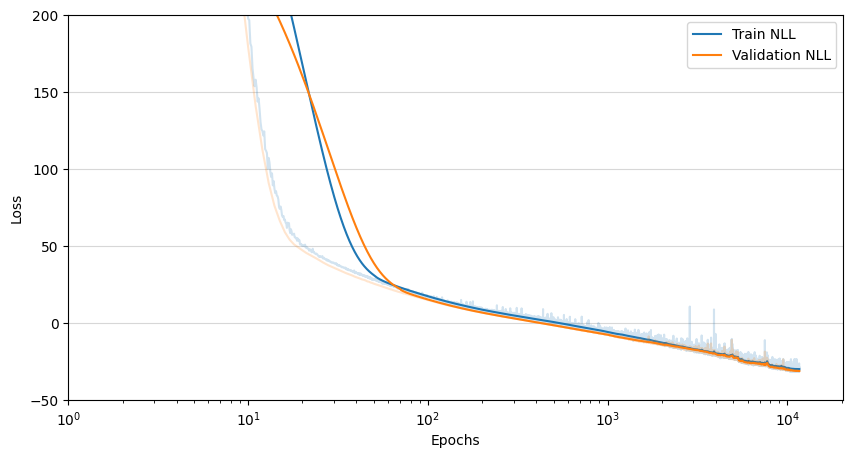

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

epochs = np.array([e for e, _ in loss_history['train']])
losses = np.array([l for _, l in loss_history['train']])

ax.plot(epochs, losses, alpha=0.2, color='C0')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=100)), label='Train NLL', color='C0')

epochs = np.array([e for e, _ in loss_history['val']])
losses = np.array([l for _, l in loss_history['val']])

ax.plot(epochs, losses, alpha=0.2, color='C1')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=20)), label='Validation NLL', color='C1')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.set_xscale('log')
ax.set_ylim(-50, 200)
ax.set_xlim(1, None)
ax.grid(axis='y', alpha=0.5)

ax.legend();

In [20]:
cnf.eval();

## Resimulation

In [21]:
N_SAMPLES = 10_000
example_id = 0

In [22]:
y_hat = cnf.sample(n_samples=N_SAMPLES, y=X_val_tensor[example_id])
y_hat = y_hat.cpu().detach().numpy()
y_hat.shape

(10000, 19)

In [25]:
y_prior = y_val_tensor.to('cpu').detach().numpy()
y_prior.shape

(400, 19)

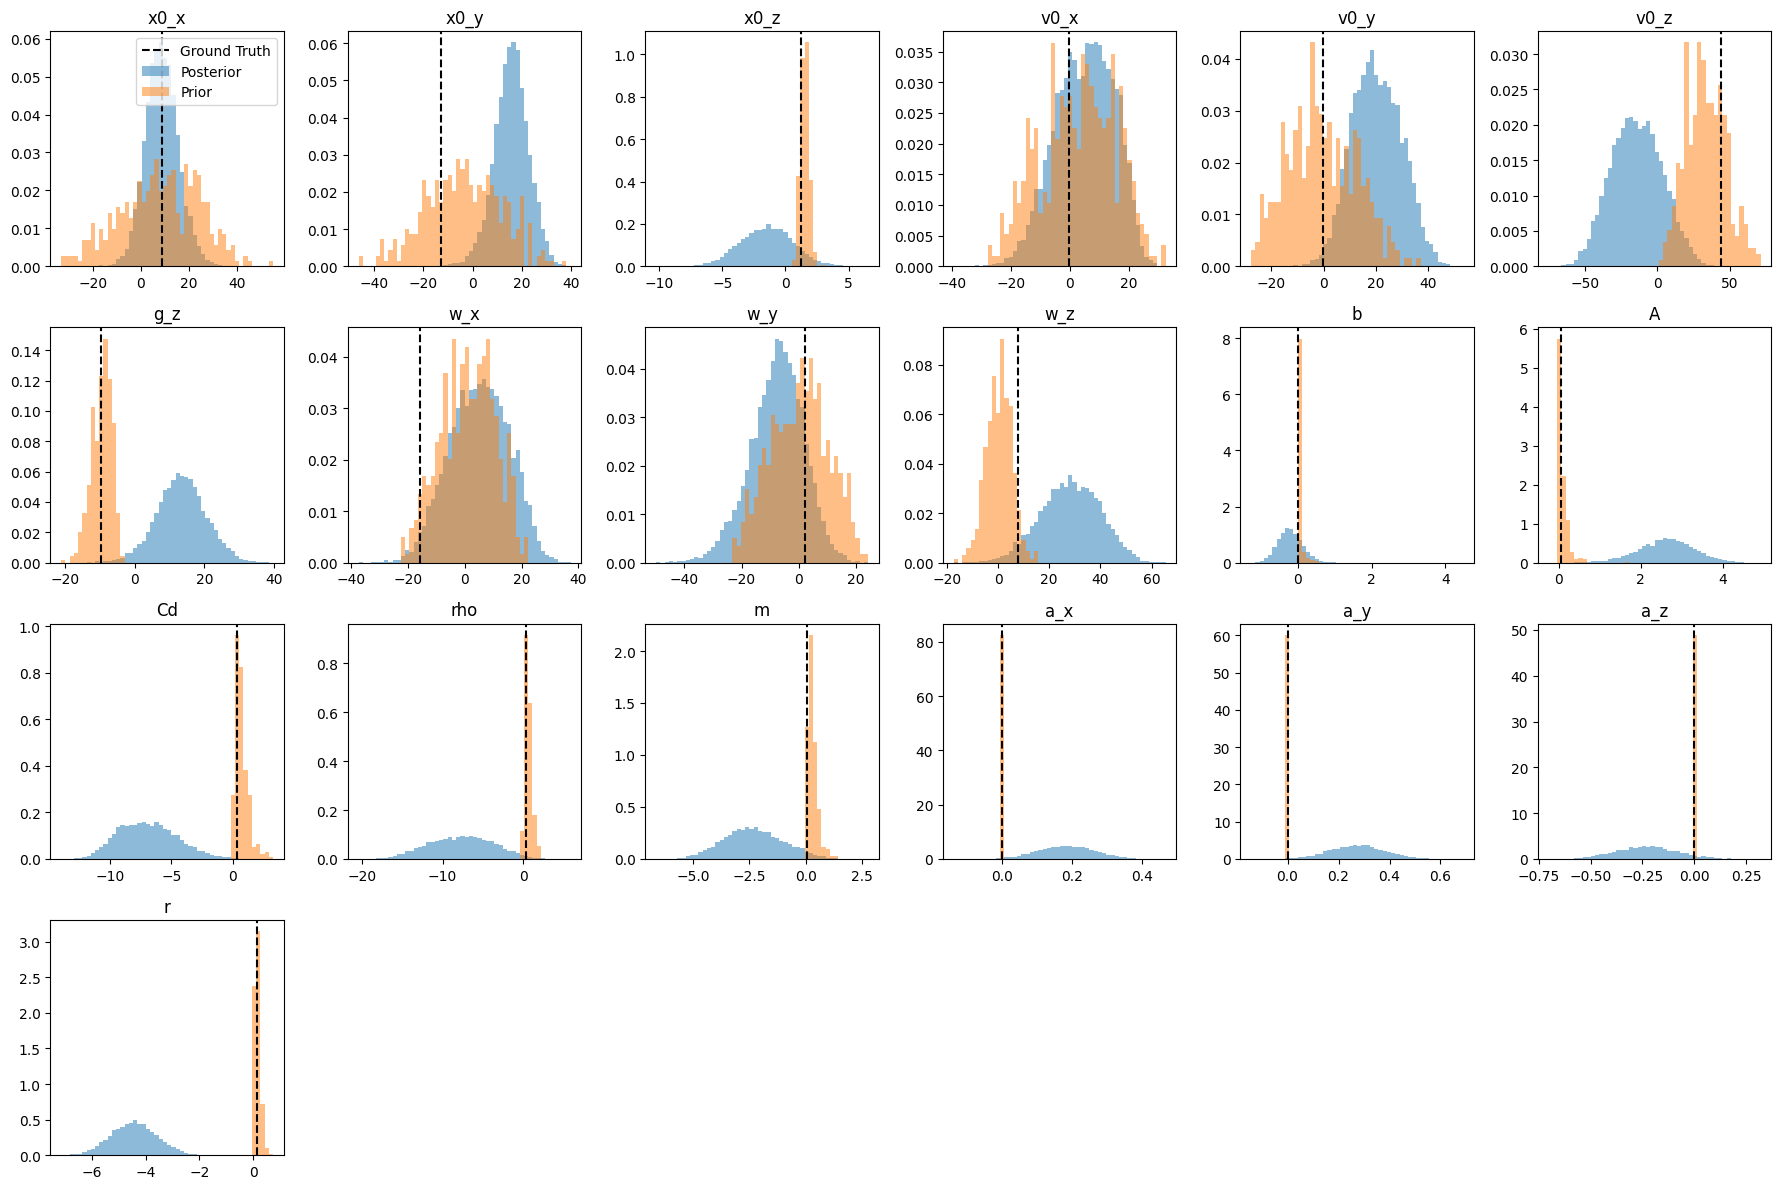

In [26]:
COLS = 6
ROWS = np.ceil(y_hat.shape[1] / COLS).astype(int)

fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3))

for i, name in zip(range(y_hat.shape[1]), cnf.parameter_index_mapping.parameters):
    vmin = np.min(np.concatenate([y_hat[:, i], y_prior[:, i]]))
    vmax = np.max(np.concatenate([y_hat[:, i], y_prior[:, i]]))
    ax.flatten()[i].axvline(y_val_tensor[example_id, i].cpu().detach().numpy(), color='k', linestyle='--', label='Ground Truth')
    ax.flatten()[i].hist(y_hat[:, i], alpha=0.5, color='C0', label='Posterior', bins=50, range=(vmin, vmax), density=True)
    ax.flatten()[i].set_title(name)

    # Show the prior
    ax.flatten()[i].hist(y_prior[:, i], alpha=0.5, color='C1', label='Prior', bins=50, range=(vmin, vmax), density=True)

for i in range(y_hat.shape[1], COLS * ROWS):
    ax.flatten()[i].axis('off')

ax[0, 0].legend()

fig.tight_layout();

# Calibration

In [33]:
from scipy.stats import binom

In [34]:
N_samples = len(X_val_tensor)
M_samples = 10_000

In [35]:
y_cal_ranks = compute_y_hat_ranks(
    model=cnf,
    X=X_val_tensor,
    y=y_val_tensor,
    M_samples=M_samples,
    batch_size=100,
    device=device,
    output_device='cpu',
    verbose=False
)

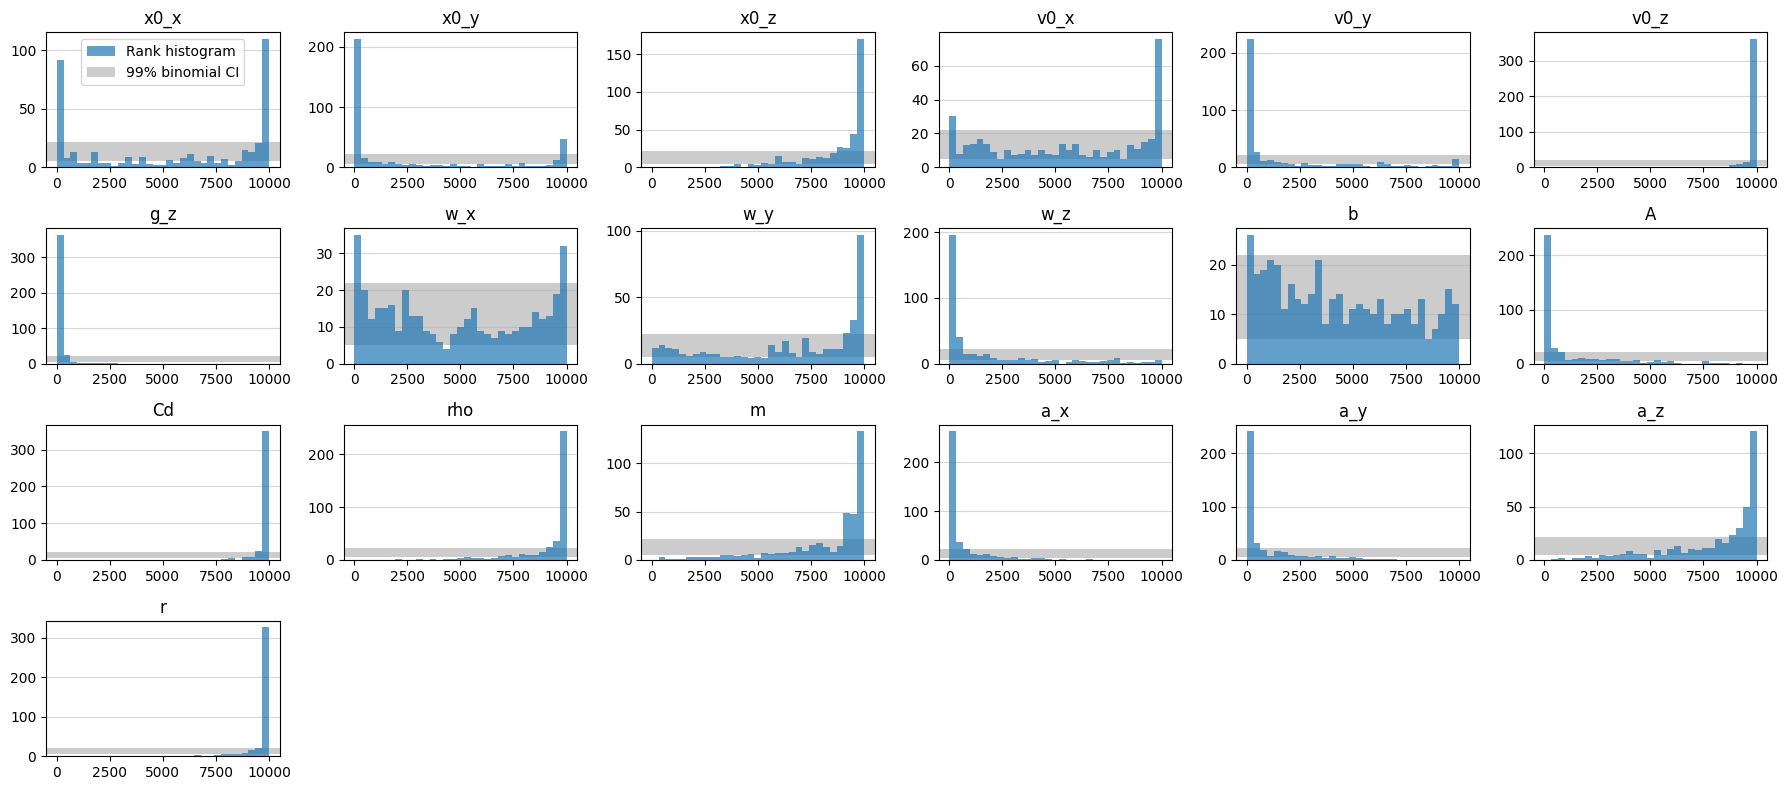

In [37]:
# Plot a histogram of the indices for each of the three parameters
COLS = 6
ROWS = np.ceil(y_cal_ranks.shape[1] / COLS).astype(int)

n_bins = 32
binomial_interval = 0.99

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2))

endpoints = binom.interval(binomial_interval, N_samples, 1 / n_bins)

n_bins_outliers = 0
n_bins_total = 0

for i, ax, name in zip(range(y_cal_ranks.shape[1]), axes.flatten(), cnf.parameter_index_mapping.parameters):
    hist = ax.hist(y_cal_ranks[:, i].detach().cpu().numpy(), bins=np.linspace(0, M_samples, n_bins), alpha=0.7, color='C0', zorder=2, label='Rank histogram')

    # Count how many bins are outside the interval
    n_bins_outliers += np.sum(hist[0] < endpoints[0]) + np.sum(hist[0] > endpoints[1])
    n_bins_total += n_bins

    ax.axhspan(endpoints[0], endpoints[1], facecolor="k", alpha=0.2, label=f'{binomial_interval * 100:.0f}% binomial CI')

    ax.set_title(name)

    ax.grid(axis='y', alpha=0.5, zorder=0)

axes[0, 0].legend()

for i in range(y_cal_ranks.shape[1], COLS * ROWS):
    axes.flatten()[i].axis('off')

fig.tight_layout()

In [38]:
print(f'Bins outside the interval: {n_bins_outliers} / {n_bins_total} ({n_bins_outliers / n_bins_total:.1%} vs {(1 - binomial_interval) * 100:.1f}% binomial interval)')

Bins outside the interval: 325 / 608 (53.5% vs 1.0% binomial interval)


In [39]:
t_linspace, scaled_residuals, confidence_interval = compute_CDF_residuals(
    y_hat_all_sorted_ranks=y_cal_ranks,
    M_samples=M_samples,
    sigma=3
)

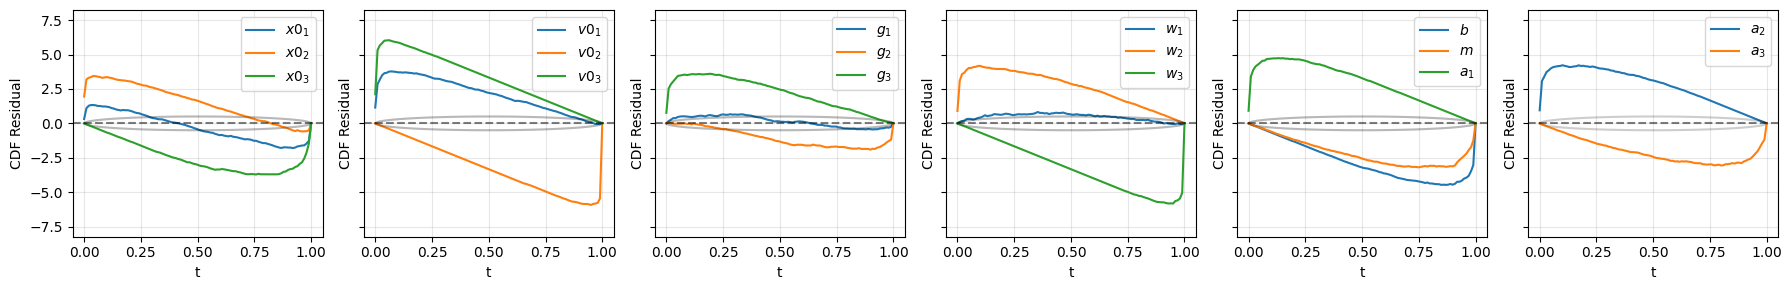

In [40]:
# Plot the residuals for X_0
n_curves_per_plot = 4
N_COLS = 6
N_ROWS = np.ceil(np.ceil(y_cal_ranks.shape[1] / n_curves_per_plot) / N_COLS).astype(int)

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(N_COLS * 3, N_ROWS * 3), sharey=True)

for indices, ax, param_names in zip(
    np.array_split(range(y_cal_ranks.shape[1]), N_ROWS * N_COLS),
    axes.flatten(),
    np.array_split(['x0_1', 'x0_2', 'x0_3', 'v0_1', 'v0_2', 'v0_3', 'g_1', 'g_2', 'g_3', 'w_1', 'w_2', 'w_3', 'b', 'm', 'a_1', 'a_2', 'a_3'], N_ROWS * N_COLS)):
    
    for j, param_name in zip(indices, param_names):
        ax.plot(t_linspace, scaled_residuals[j, :], label=f"${param_name}$")

        ax.plot(t_linspace, confidence_interval, color='black', alpha=0.1)
        ax.plot(t_linspace, -confidence_interval, color='black', alpha=0.1)

    ax.set_xlabel("t")
    ax.set_ylabel("CDF Residual")

    ax.axhline(0, color='black', linestyle='--', alpha=0.5)

    ax.legend()

    ylim = max(np.abs(scaled_residuals[indices, :].min()), np.abs(scaled_residuals[indices, :].max()))

    ax.set_ylim(-ylim * 1.5, ylim * 1.5)

    ax.grid(alpha=0.3)

fig.tight_layout()